In [68]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import jax.random as jr
import jax.numpy as jnp
import gpjax as gpx
from jax import jit

In [69]:
from jax import config
config.update("jax_enable_x64", True)

In [70]:
# Read data from json file
df = pd.read_json("testdata/oscillation_data.json")
df_test = pd.read_json("testdata/oscillation_data_original.json")

In [71]:
# some plotting defaults
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
key = jr.PRNGKey(123)
key, subkey = jr.split(key)

In [72]:
# save data from df to jax array
X = jnp.array(df["t_values"]).reshape(-1,1)
y = jnp.array(df["y_values"]).reshape(-1,1)

# save the original data
xtest = jnp.array(df_test["t_values"]).reshape(-1,1)
ytest = jnp.array(df_test["y_values"]).reshape(-1,1)

In [73]:
print (X.shape, y.shape)

(50, 1) (50, 1)


In [74]:
# save the data in a gpx.Dataset object
D = gpx.Dataset(X=X, y=y)

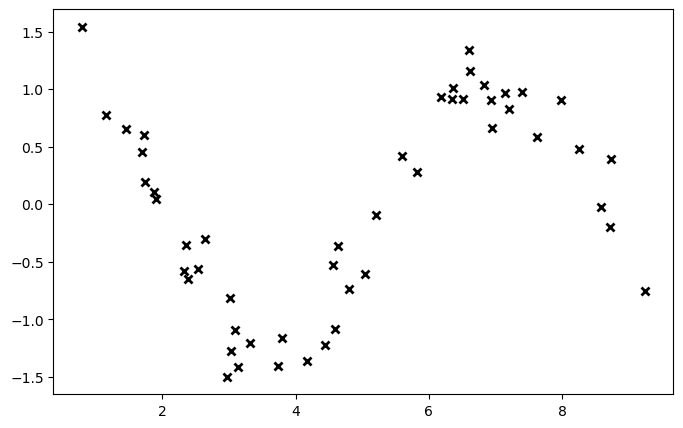

In [75]:
# plot scattered data
plt.figure(figsize=(8, 5))
plt.plot(X, y, "kx", mew=2)
plt.show()

In [76]:
mean = gpx.mean_functions.Zero()
kernel = gpx.kernels.RBF()
prior = gpx.gps.Prior(mean_function = mean, kernel = kernel)

print (type(mean))
print (type(kernel))
print (type(prior))

<class 'gpjax.mean_functions.Zero'>
<class 'gpjax.kernels.stationary.rbf.RBF'>
<class 'gpjax.gps.Prior'>


We write a GP $f(\cdot) \sim \mathcal{GP}(\mu(\cdot), k(\cdot, \cdot))$ with mean function $\mu: \mathcal{X} \rightarrow \mathbb{R}$ and $\boldsymbol{\theta}$-parameterised kernel $k: \mathcal{X} \times \mathcal{X}\rightarrow \mathbb{R}$. When evaluating the GP on a finite set of points $\mathbf{X}\subset\mathcal{X}$, $k$ gives rise to the Gram matrix $\mathbf{K}_{ff}$ such that the $(i, j)^{\text{th}}$ entry of the matrix is given by $[\mathbf{K}_{ff}]_{i, j} = k(\mathbf{x}_i, \mathbf{x}_j)$. As is conventional within the literature, we centre our training data and assume $\mu(\mathbf{X}):= 0$ for all $\mathbf{X}\in\mathbf{X}$. We further drop dependency on $\boldsymbol{\theta}$ and $\mathbf{X}$ for notational convenience in the remainder of this article.



We define a joint GP prior over the latent function

\begin{align}
p\left(\mathbf{f}, \mathbf{f}^{\star}\right)=\mathcal{N}\left(\mathbf{0},\left[\begin{array}{ll}
\mathbf{K}_{x f} & \mathbf{K}_{x x}
\end{array}\right]\right)
\end{align}

where $\mathbf{f}^{\star} = f(\mathbf{X}^{\star})$. Conditional on the GP's latent function $f$, we assume a factorising likelihood generates our observations

\begin{align}
p(\mathbf{y} \mid \mathbf{f})=\prod_{i=1}^n p\left(y_i \mid f_i\right)
\end{align}

Strictly speaking, the likelihood function is $p(\mathbf{y}\,|\,\phi(\mathbf{f}))$ where $\phi$ is the likelihood function's associated link function. Example link functions include the probit or logistic functions for a Bernoulli likelihood and the identity function for a Gaussian likelihood. We eschew this notation for now as this section primarily considers Gaussian likelihood functions where the role of $\phi$ is superfluous. However, this intuition will be helpful for models with a non-Gaussian likelihood, such as those encountered in classification.



Applying Bayes' theorem (???) yields the joint posterior distribution over the latent function
\begin{equation*}
p\left(\mathbf{f}, \mathbf{f}^{\star} \mid \mathbf{y}\right)=\frac{p(\mathbf{y} \mid \mathbf{f}) p\left(\mathbf{f}, \mathbf{f}^{\star}\right)}{p(\mathbf{y})} .
\end{equation*}

The choice of kernel function that we use to parameterise our GP is an important modelling decision as the choice of kernel dictates properties such as differentiability, variance and characteristic lengthscale of the functions that are admissible under the GP prior. A kernel is a positive-definite function with parameters $\boldsymbol{\theta}$ that maps pairs of inputs $\mathbf{X}, \mathbf{X}' \in \mathcal{X}$ onto the real line. We dedicate the entirety of the Introduction to Kernels notebook to exploring the different GPs each kernel can yield.

In [77]:
# What is this doing?
prior_dist = prior.predict(xtest)
prior_mean = prior_dist.mean()
prior_std = prior_dist.variance()
samples = prior_dist.sample(seed=key, sample_shape=(20,))


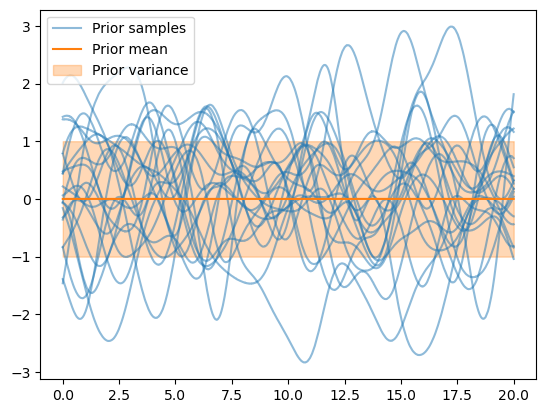

In [78]:
# plot the 20 samples of the prior
fig, ax = plt.subplots()
ax.plot(xtest, samples.T, alpha=0.5, color=cols[0], label="Prior samples")
ax.plot(xtest, prior_mean, color=cols[1], label="Prior mean")
ax.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    color=cols[1],
    label="Prior variance",
)
ax.legend(loc="best")

# Remove repeated labels in legend
handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique))

## Constructing the Posteriors

Having defined our GP, we proceed to define a description of our data $\mathcal{D}$ conditional on our knowledge of $f(\cdot)$--- this is exactly the notion of a likelihood function $p(\mathcal{D} \mid f(\cdot))$. While the choice of likelihood is a critical in Bayesian modelling, for simplicity we consider a Gaussian with noise parameter $\alpha$
\begin{equation*}
p(\mathcal{D} \mid f(\cdot))=\mathcal{N}\left(\boldsymbol{y} ; f(\boldsymbol{x}), \mathbf{I} \alpha^2\right) .
\end{equation*}

This is defined in GPJax through calling a Gaussian instance.

In [79]:
# Create Dataset, D
D = gpx.Dataset(X=X, y=y)

In [80]:
# Construct GP likelihood
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)

The posterior is proportional to the prior multiplied by the likelihood, written as
\begin{equation*}
p(f(\cdot) \mid \mathcal{D}) \propto p(f(\cdot)) * p(\mathcal{D} \mid f(\cdot)) .
\end{equation*}

Mimicking this construct, the posterior is established in GPJax through the * operator.

In [81]:
# Construct posterior
posterior = prior * likelihood

In [82]:
# Create a negative marginal log likelihood
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll(posterior, train_data=D)

Array(56.04655905, dtype=float64)

In [83]:
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=negative_mll,
    train_data=D
)

Initial loss is 56.046559048591085
Optimization was successful
Final loss is 11.464098430978323 after 18 iterations


In [84]:
latent_dist = opt_posterior.predict(xtest, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)
predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

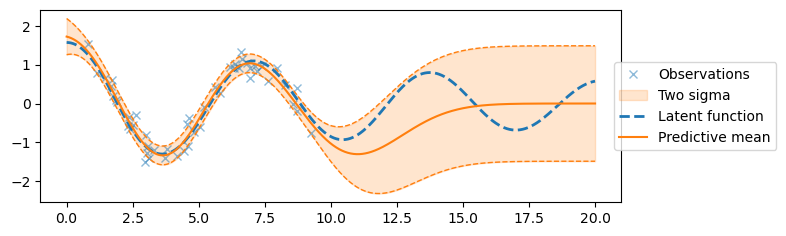

In [85]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(X, y, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - 1 * predictive_std,
    predictive_mean + 1 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean - 1 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean + 1 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest, ytest, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
plt.show()